In [19]:
import warnings
warnings.filterwarnings('ignore')

In [20]:
# imports
import pydicom as dcm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import re
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import skops.io as sio
import shutil
import os

In [22]:
os.environ['PYTHONHASHSEED'] = str(42)
np.random.seed(42)

In [ ]:
# def getMiddleTen(total_count):
#     middle_count = total_count//2
#     start_idx = middle_count - 5
#     end_idx = middle_count + 5
#     return start_idx, end_idx

# patients = glob('./train/*')

# for patient in patients:
#     currPatient = sorted(glob(patient + '/*'), key=lambda x: int(re.search(r"\/(\d+)", x).group(1)))
#     new_folder = './filtered_images/' + patient.split('/')[2]
#     os.mkdir(new_folder)
#     total_pics = len(currPatient)
#     start_idx, end_idx = getMiddleTen(total_pics)
#     for i in range(start_idx, end_idx+1):  
#         source_pic = currPatient[i]
#         shutil.copy(source_pic, new_folder)

In [23]:
df = pd.read_csv('train.csv')
df

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker
...,...,...,...,...,...,...,...
1544,ID00426637202313170790466,13,2712,66.594637,73,Male,Never smoked
1545,ID00426637202313170790466,19,2978,73.126412,73,Male,Never smoked
1546,ID00426637202313170790466,31,2908,71.407524,73,Male,Never smoked
1547,ID00426637202313170790466,43,2975,73.052745,73,Male,Never smoked


In [24]:
# patient_ids = df['Patient'].unique()
# for patient in patient_ids:
#     plt.figure(figsize=(10,6))
#     data = df[df['Patient']==patient]
#     y = data['FVC'].tolist()
#     x = data['Weeks'].tolist()
#     plt.title(patient)
#     plt.ylabel('FVC')
#     plt.xlabel('Weeks')
#     plt.plot(x, y)
#     plt.show()

In [25]:
df.head(20)

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker
5,ID00007637202177411956430,17,2101,52.868646,79,Male,Ex-smoker
6,ID00007637202177411956430,29,2000,50.327126,79,Male,Ex-smoker
7,ID00007637202177411956430,41,2064,51.937594,79,Male,Ex-smoker
8,ID00007637202177411956430,57,2057,51.761449,79,Male,Ex-smoker
9,ID00009637202177434476278,8,3660,85.282878,69,Male,Ex-smoker


In [26]:
X = df.drop(['Patient', 'FVC'], axis=1)
y = df['FVC']

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
encoder_sex = LabelEncoder()
X_train['Sex'] = encoder_sex.fit_transform(X_train['Sex'])
X_test['Sex'] = encoder_sex.transform(X_test['Sex'])

In [29]:
encoder_smoking = LabelEncoder()
X_train['SmokingStatus'] = encoder_smoking.fit_transform(X_train['SmokingStatus'])
X_test['SmokingStatus'] = encoder_smoking.transform(X_test['SmokingStatus'])

In [30]:
X_train['Percent'] = X_train['Percent']/100
X_test['Percent'] = X_test['Percent']/100

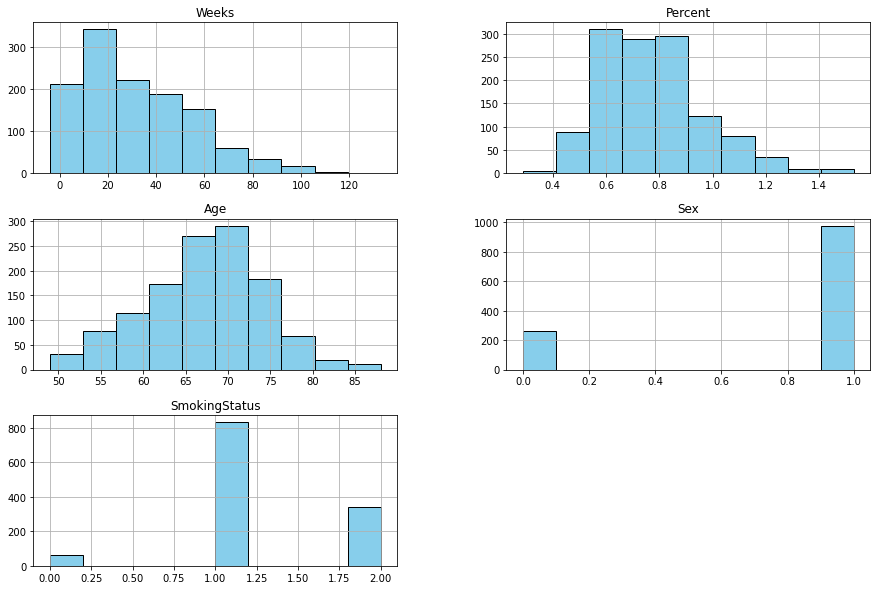

In [31]:
X_train.hist(figsize=(15,10), color='skyblue', edgecolor='black');

In [59]:
X_train

,Weeks,Percent,Age,Sex,SmokingStatus
1249,25,0.659210,72,1,1
1048,22,0.734663,63,0,1
1159,69,1.237967,72,1,1
818,34,0.817905,81,1,1
741,0,0.737905,65,1,0
...,...,...,...,...,...
1130,18,0.799569,73,1,2
1294,12,0.459174,65,1,1
860,19,0.504938,77,0,2
1459,58,0.613062,61,0,2


In [32]:
# import optuna
# import xgboost as xgb
# from sklearn.metrics import mean_squared_error
# from sklearn.model_selection import train_test_split


# # Define the objective function
# def objective(trial):
#     param = {
#         'verbosity': 0,
#         'objective': 'reg:squarederror',
#         'tree_method': 'exact',  # Consider using 'gpu_hist' if you're on a GPU
#         'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
#         'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
#         'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]),
#         'subsample': trial.suggest_categorical('subsample', [0.6, 0.7, 0.8, 0.9, 1.0]),
#         'learning_rate': trial.suggest_categorical('learning_rate', [0.01, 0.02, 0.05, 0.1]),
#         'n_estimators': trial.suggest_categorical('n_estimators', [100, 500, 1000]),
#         'max_depth': trial.suggest_int('max_depth', 3, 9),
#         'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
#     }
    
#     model = xgb.XGBRegressor(**param)
#     model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=50, verbose=False)
    
#     preds = model.predict(X_test)
#     mse = mean_squared_error(y_test, preds, squared=False)
#     return mse

# # Create a study object and optimize the objective function
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=100)

# # Best trial
# trial = study.best_trial
# print(f'Lowest MSE: {trial.value}')
# print("Best hyperparameters: {}".format(trial.params))


[I 2024-05-17 10:01:57,732] A new study created in memory with name: no-name-dd9b62ff-cc6f-4c9b-a816-6b258f5876dd
[I 2024-05-17 10:01:57,849] Trial 0 finished with value: 536.3020334081707 and parameters: {'lambda': 3.663398395116079, 'alpha': 0.007263698879469463, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.05, 'n_estimators': 500, 'max_depth': 3, 'min_child_weight': 206}. Best is trial 0 with value: 536.3020334081707.
[I 2024-05-17 10:02:00,508] Trial 1 finished with value: 239.07522981321446 and parameters: {'lambda': 0.526438686643007, 'alpha': 0.025569509894607267, 'colsample_bytree': 1.0, 'subsample': 0.9, 'learning_rate': 0.05, 'n_estimators': 1000, 'max_depth': 8, 'min_child_weight': 63}. Best is trial 1 with value: 239.07522981321446.
[I 2024-05-17 10:02:00,649] Trial 2 finished with value: 249.11294197588936 and parameters: {'lambda': 0.4618938654881263, 'alpha': 0.17948384715113933, 'colsample_bytree': 1.0, 'subsample': 0.9, 'learning_rate': 0.1, 'n_estimat

Lowest RMSE: 199.0959241656543
Best hyperparameters: {'lambda': 0.17825857820210467, 'alpha': 4.864221430938174, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.01, 'n_estimators': 500, 'max_depth': 8, 'min_child_weight': 5}


In [33]:
# params = trial.params

In [34]:
# xgb = XGBRegressor(**params)
# xgb.fit(X_train, y_train)

XGBRegressor(alpha=4.864221430938174, base_score=None, booster=None,
             callbacks=None, colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=0.17825857820210467,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
             max_leaves=None, min_child_weight=5, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, ...)

In [35]:
# y_pred = xgb.predict(X_test)

In [ ]:
params

In [36]:
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# mean_squared_error(y_test, y_pred), mean_absolute_error(y_test, y_pred), r2_score(y_test, y_pred) 

(39339.63644189317, 143.0667238297001, 0.9345842348814063)

In [37]:
# # model saving


# # Assuming 'model' is your trained XGBRegressor model
# sio.dump(xgb, "xgb.skops")


In [39]:
from sklearn.utils import resample
# Example training data: X_train, y_train
# Example test data: X_test

# Define the number of bootstrap samples
n_bootstraps = 100

# Initialize an array to store predicted FVC values for each bootstrap sample
fvc_predictions = np.zeros((n_bootstraps, len(X_test)))

# Train a model for each bootstrap sample and make predictions
for i in range(n_bootstraps):
    # Generate a bootstrap sample
    X_boot, y_boot = resample(X_train, y_train, random_state=i)
    
    # Train a model (example: Random Forest Regressor)
    model = sio.load("xgb.skops", trusted=True)
    model.fit(X_boot, y_boot)
    
    # Make predictions on test data
    fvc_predictions[i] = model.predict(X_test)
fvc_predictions

array([[2885.70410156, 2609.53881836, 2707.5715332 , ..., 2231.6706543 ,
        2693.9909668 , 2457.43017578],
       [2855.53613281, 2397.65649414, 2622.56469727, ..., 2242.4855957 ,
        2489.99902344, 2478.69970703],
       [2806.64086914, 2349.24731445, 2614.84765625, ..., 2368.02978516,
        2571.71508789, 2454.07885742],
       ...,
       [2860.54248047, 2301.26660156, 2521.31738281, ..., 2318.3269043 ,
        2579.81738281, 2421.44702148],
       [2871.29467773, 2691.98803711, 2588.90014648, ..., 2260.52905273,
        2560.93505859, 2377.36669922],
       [2876.97851562, 2272.72753906, 2670.57006836, ..., 2312.01074219,
        2588.96972656, 2462.42822266]])

In [40]:

# Calculate the standard deviation of predicted FVC values across bootstrap samples
prediction_std_dev = np.std(fvc_predictions, axis=0)
prediction_std_dev

array([ 58.01856999, 191.53708056,  63.37960092,  70.09520707,
        69.74997655,  50.03055567,  42.44477509,  54.27351114,
        71.78051787,  73.62521776, 117.96398212, 118.5321155 ,
        47.82142693, 100.28794318,  40.67612348,  50.17633694,
        34.94094379,  78.59381882,  75.98234572,  70.01013946,
        21.25283501,  54.90616954,  29.36634556,  57.44062189,
        43.07577672,  65.03578877,  56.85733973,  47.0507437 ,
        82.80645608,  50.25530889,  79.99710183,  65.41088841,
        45.49513663,  49.59473606,  80.4636772 ,  50.06546446,
        54.8772677 ,  42.491915  , 132.97164029,  82.83132114,
        52.54968382,  47.87023379,  34.10134871,  28.6580639 ,
        71.99672539,  65.25676079,  79.69348577,  40.96282215,
        64.12803335,  44.49817289,  71.7118036 ,  86.83813506,
        45.993786  , 147.50509285,  47.99022498,  57.35484191,
        65.45529117,  42.19001785,  78.82542064,  94.13799384,
       136.5670274 ,  43.74160859,  76.08944372,  55.98

In [41]:

import numpy as np

# Example predicted values and their associated standard deviations
predicted_values =  model.predict(X_test)  # Example predicted values
standard_deviations = prediction_std_dev    # Example standard deviations

# Define the confidence level (e.g., 95% confidence level corresponds to alpha = 0.05)
alpha = 0.05

# Calculate the z-score corresponding to the desired confidence level (assuming normal distribution)
z_score = np.abs(np.percentile(np.random.normal(size=10000), alpha/2 * 100))

# Calculate the confidence interval for each predicted value
confidence_intervals = z_score * standard_deviations

# Compute the lower and upper bounds of the confidence intervals
lower_bounds = predicted_values - confidence_intervals
upper_bounds = predicted_values + confidence_intervals

In [42]:
# Print the results
confidence = []
for i in range(len(predicted_values)):
    confidence.append((upper_bounds[i]-lower_bounds[i])/predicted_values[i])

In [43]:
import numpy as np

def custom_metrics(prediction_std_dev, predicted_values, actual_values):
    prediction_std_dev = np.array(prediction_std_dev)
    predicted_values = np.array(predicted_values)
    actual_values = np.array(actual_values)

    std_clipped = np.maximum(prediction_std_dev, 70)
    delta = np.minimum((predicted_values - actual_values), 1000)
    metric = -(np.sqrt(2) * delta / std_clipped) - np.log(np.sqrt(2) * std_clipped)
    
    return np.mean(metric)


In [44]:
custom_metrics(prediction_std_dev, predicted_values, np.array(y_test)) # maybe we broke the score

-4.845053066206157

In [45]:
# testing time
test_df = pd.read_csv('test.csv')
test_df

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00419637202311204720264,6,3020,70.186855,73,Male,Ex-smoker
1,ID00421637202311550012437,15,2739,82.045291,68,Male,Ex-smoker
2,ID00422637202311677017371,6,1930,76.672493,73,Male,Ex-smoker
3,ID00423637202312137826377,17,3294,79.258903,72,Male,Ex-smoker
4,ID00426637202313170790466,0,2925,71.824968,73,Male,Never smoked


In [46]:
test_df['Percent'] = test_df['Percent']/100
test_df['SmokingStatus'] = encoder_smoking.transform(test_df['SmokingStatus'])

In [47]:
test_df['Sex'] = encoder_sex.transform(test_df['Sex'])

In [48]:
test_df

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00419637202311204720264,6,3020,0.701869,73,1,1
1,ID00421637202311550012437,15,2739,0.820453,68,1,1
2,ID00422637202311677017371,6,1930,0.766725,73,1,1
3,ID00423637202312137826377,17,3294,0.792589,72,1,1
4,ID00426637202313170790466,0,2925,0.718250,73,1,2


In [49]:
test_data = test_df.drop(['Patient', 'FVC'], axis=1)

In [50]:
from sklearn.utils import resample
# Example training data: X_train, y_train
# Example test data: X_test

# Define the number of bootstrap samples
n_bootstraps = 100

# Initialize an array to store predicted FVC values for each bootstrap sample
fvc_predictions = np.zeros((n_bootstraps, len(test_data)))

# Train a model for each bootstrap sample and make predictions
for i in range(n_bootstraps):    
    X_boot = resample(test_data, random_state=i)
    # Make predictions on test data
    fvc_predictions[i] = model.predict(X_boot)

# Calculate the standard deviation of predicted FVC values across bootstrap samples
prediction_std_dev = np.std(fvc_predictions, axis=0)
prediction_std_dev

array([432.9371145 , 359.51637366, 381.79255244, 393.81863143,
       392.84252666])

In [51]:
fvc_predictions

array([[2886.16064453, 2557.46582031, 3169.80566406, 3169.80566406,
        3169.80566406],
       [3169.80566406, 2886.16064453, 2557.46582031, 2909.35742188,
        3169.80566406],
       [2557.46582031, 2557.46582031, 3169.80566406, 2018.51257324,
        3169.80566406],
       [2018.51257324, 2557.46582031, 2909.35742188, 3169.80566406,
        2557.46582031],
       [2018.51257324, 2909.35742188, 2557.46582031, 2557.46582031,
        2018.51257324],
       [3169.80566406, 2557.46582031, 2909.35742188, 2557.46582031,
        2886.16064453],
       [2018.51257324, 2909.35742188, 3169.80566406, 2886.16064453,
        2018.51257324],
       [2886.16064453, 2909.35742188, 3169.80566406, 3169.80566406,
        2886.16064453],
       [3169.80566406, 2886.16064453, 2909.35742188, 2909.35742188,
        2018.51257324],
       [2886.16064453, 2557.46582031, 3169.80566406, 2909.35742188,
        2886.16064453],
       [2909.35742188, 2886.16064453, 2557.46582031, 2909.35742188,
        3169

In [52]:
predicted_values =  model.predict(test_data)  # Example predicted values
standard_deviations = prediction_std_dev    # Example standard deviations

# Define the confidence level (e.g., 95% confidence level corresponds to alpha = 0.05)
alpha = 0.05

# Calculate the z-score corresponding to the desired confidence level (assuming normal distribution)
z_score = np.abs(np.percentile(np.random.normal(size=10000), alpha/2 * 100))

# Calculate the confidence interval for each predicted value
confidence_intervals = z_score * standard_deviations

# Compute the lower and upper bounds of the confidence intervals
lower_bounds = predicted_values - confidence_intervals
upper_bounds = predicted_values + confidence_intervals

In [53]:
confidence = []
for i in range(len(predicted_values)):
    confidence.append((upper_bounds[i]-lower_bounds[i])/predicted_values[i])

In [54]:
custom_metrics(prediction_std_dev, predicted_values, np.array(test_df['FVC']))

-6.096737656616184

In [55]:
test_df

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00419637202311204720264,6,3020,0.701869,73,1,1
1,ID00421637202311550012437,15,2739,0.820453,68,1,1
2,ID00422637202311677017371,6,1930,0.766725,73,1,1
3,ID00423637202312137826377,17,3294,0.792589,72,1,1
4,ID00426637202313170790466,0,2925,0.718250,73,1,2


In [56]:
submission_data = test_df.copy()
submission_data

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00419637202311204720264,6,3020,0.701869,73,1,1
1,ID00421637202311550012437,15,2739,0.820453,68,1,1
2,ID00422637202311677017371,6,1930,0.766725,73,1,1
3,ID00423637202312137826377,17,3294,0.792589,72,1,1
4,ID00426637202313170790466,0,2925,0.718250,73,1,2


In [57]:
test = []
for i in range(-12, 113):
    test.append(model.predict([[i, 0.701869, 73, 1, 1]]))

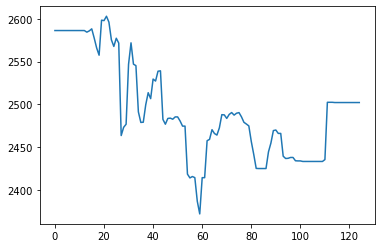

In [58]:
plt.plot(test)